In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

# Set seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)
pd.set_option("display.max_columns", None)

In [5]:
# Technical indicators
trend_indicators = ["DMN_5", "DMN_10", "ADX_5", "ADX_10", "DMP_5"]
oscillators =["MACD_8_21_5", "STOCHd_7_3_3", "RSI_7"]
moving_averages = ["MA_20", "KAMA_3_2_10", "EMA_15", "MA_10"]
volatility_indicators = ["Bollinger_Lower", "Bollinger_Upper"]
other_indicators = []
technical_indicators = (
    trend_indicators + oscillators + moving_averages + volatility_indicators + other_indicators
)

# LOB specific indicators
mid_price_indicators = ["std_mid_price", "weighted_mid_price_variation", "mean_mid_price_variation"]
bid_ask_prices_indicators = ["std_spread", "mean_spread"]
volume_indicators = ["total_bid_volume", "total_ask_volume", "std_best_bid_size", "std_best_ask_size"]
orders_indicators = ["mean_order_book_imbalance", "order_book_imbalance_5s", "order_flow_5s", "last_order_book_imbalance", "total_net_order_flow"]
lob_indicators = mid_price_indicators + bid_ask_prices_indicators + volume_indicators + orders_indicators

time_indicators = ['time_since_open']

# Feature list
features =  lob_indicators + time_indicators

In [6]:
# Parameters
sampling_rate = "2s"
prediction_column = "mean_mid_price_variation_class"
batch_size = 32
look_back = 12

In [7]:
raw_data = pd.read_parquet("all_data.parquet")

start_date = "2024-11-20"
end_date = "2024-11-22"

all_data = raw_data.loc[start_date:end_date]

all_data.head()

,mid_price_first,mid_price_last,mid_price_high,mid_price_low,mid_price_mean,std_mid_price,weighted_mid_price_first,weighted_mid_price_last,weighted_mid_price_mean,last_spread,mean_spread,std_spread,last_best_bid_price,mean_best_bid_price,last_best_ask_price,mean_best_ask_price,last_best_bid_size,mean_best_bid_size,std_best_bid_size,last_best_ask_size,mean_best_ask_size,std_best_ask_size,mean_second_ask_price,mean_second_bid_price,mid_price_variation,mid_price_variation_class,mean_mid_price_variation,mean_mid_price_variation_class,next_5_mean_mid_price_variation_class,weighted_mid_price_variation,weighted_mid_price_variation_class,total_bid_volume,total_ask_volume,mean_order_book_imbalance,last_order_book_imbalance,total_net_order_flow,num_added_orders,num_canceled_orders,num_traded_orders,order_book_imbalance_5s,order_flow_5s,bid_volume_variation,ask_volume_variation,bid_price_variation,ask_price_variation,trade_open,trade_close,trade_high,trade_low,ADX_5,ADX_7,ADX_10,DMP_5,DMP_10,DMN_5,DMN_10,AROONU_7,AROOND_7,OLL3,OLL5,OLL10,OLL15,OHH3,OHH5,STOCHk_7_3_3,STOCHd_7_3_3,MACD_8_21_5,RSI_7,AO_5_10,EMA_15,HMA_10,KAMA_3_2_10,MA_10,MA_20,rmCO(3),rmCO(4),rmCO(5),rmCO(6),Bollinger_Upper,Bollinger_Lower,U_minus_L,MA20dSTD,CO,C1O1,C2O2,C3O3,range,OH1,time_since_open,is_monday,is_tuesday,is_wednesday,is_thursday,is_friday
ts_recv,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-20 09:30:56-05:00,229.325,229.385,229.385,229.320,229.346195,0.022021,229.358077,229.399971,229.356614,0.03,0.038938,0.008901,229.37,229.326726,229.40,229.365664,1030.0,323.221239,334.961478,1.0,24.000000,24.069839,229.377168,229.316106,0.000262,2.0,0.000092,1,0,0.000183,1,4523.0,-13.0,0.861122,0.998060,1029,58.0,41.0,14,0.146294,365.2,499.0,-14.0,0.0,0.0,229.32,229.39,229.39,229.31,47.203090,46.412512,49.032433,59.767528,45.829304,7.788200,10.392367,100.000000,28.571429,0.110,0.170,0.195,0.305,0.060,0.060,100.000000,90.277778,0.010229,81.395207,0.03650,229.190758,229.236885,229.264841,229.215915,229.171010,0.051667,0.04875,0.043,0.035833,229.303329,229.038690,0.264640,0.082172,0.060,0.110,-0.015,0.040,0.065,0.110,56.0,0,0,1,0,0
2024-11-20 09:30:58-05:00,229.385,229.410,229.415,229.370,229.393070,0.014181,229.399971,229.422392,229.400018,0.04,0.034035,0.010107,229.39,229.376053,229.43,229.410088,430.0,407.184211,306.556021,101.0,84.149123,58.818038,229.426404,229.362719,0.000109,2.0,0.000035,1,0,0.000098,1,-418.0,-169.0,0.657395,0.619586,329,52.0,51.0,11,0.260951,345.0,-600.0,100.0,0.0,0.0,229.40,229.42,229.42,229.37,53.822734,49.985034,50.709842,60.783861,47.164429,6.640896,9.726491,100.000000,14.285714,0.170,0.195,0.255,0.365,0.030,0.030,98.245614,99.415205,0.015114,84.584455,0.05775,229.216047,229.269095,229.321832,229.235384,229.188106,0.065000,0.04500,0.044,0.040000,229.340842,229.035370,0.305472,0.090966,0.025,0.060,0.110,-0.015,0.045,0.060,58.0,0,0,1,0,0
2024-11-20 09:31:00-05:00,229.410,229.310,229.445,229.290,229.366740,0.051199,229.422392,229.299412,229.368376,0.04,0.048879,0.013822,229.29,229.342301,229.33,229.391180,100.0,161.038348,177.266177,325.0,122.643068,113.709011,229.406165,229.329204,-0.000436,0.0,-0.000189,0,0,-0.000536,0,-428.0,3000.0,0.137478,-0.529412,-225,138.0,130.0,71,0.291805,317.0,-330.0,224.0,0.0,0.0,229.39,229.30,229.47,229.29,47.332652,46.949741,49.202097,37.193404,37.876380,24.094710,17.975144,100.000000,0.000000,0.120,0.195,0.280,0.390,0.035,0.035,53.448276,83.897963,0.012316,76.042314,0.06950,229.234883,229.292978,229.332478,229.253130,229.200741,-0.005000,0.02375,0.016,0.020000,229.367996,229.033486,0.334511,0.094111,-0.100,0.025,0.060,0.110,0.155,0.030,60.0,0,0,1,0,0
2024-11-20 09:31:02-05:00,229.310,229.175,229.310,229.175,229.251882,0.047008,229.300183,229.194902,229.256919,0.07,0.053878,0.023963,229.14,229.224943,229.21,229.278821,200.0,140.673004,91.670624,55.0,121.684411,112.354415,229.293194,229.206464,-0.000589,0.0,-0.000253,0,0,-0.000459,0,415.0,1270.0,0.072420,0.5686

In [8]:
all_data[prediction_column].value_counts()

mean_mid_price_variation_class
0    14410
1    12349
Name: count, dtype: int64

In [9]:
# Data splitting
train_size = int(len(all_data) * 0.5)
val_size = int(len(all_data) * 0.1)
test_size = len(all_data) - train_size - val_size

train_df = all_data.iloc[:train_size, :]
val_df = all_data.iloc[train_size : train_size + val_size, :]
test_df = all_data.iloc[train_size + val_size :, :]

In [10]:
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler

class ScaledTimeSeriesDataset(Dataset):
    def __init__(self, data, target, features, look_back):
        self.data = data[features].values
        self.targets = data[target].values.astype(int)
        self.features = features
        self.look_back = look_back

    def __len__(self):
        return len(self.data) - self.look_back

    def __getitem__(self, idx):
        sequence = self.data[idx : idx + self.look_back]
        target = self.targets[idx + self.look_back]

        # Apply scaling for each training example
        scaler = MinMaxScaler(feature_range=(0, 1))
        sequence = scaler.fit_transform(sequence)

        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(
            target, dtype=torch.long
        )


In [11]:
# Create datasets
train_dataset = ScaledTimeSeriesDataset(train_df, prediction_column, features, look_back)
val_dataset = ScaledTimeSeriesDataset(val_df, prediction_column, features, look_back)
test_dataset = ScaledTimeSeriesDataset(test_df, prediction_column, features, look_back)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# Define the PyTorch model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size2, 32)
        self.dropout3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = x.permute(0, 2, 1)  # Reshape for BatchNorm
        x = self.bn1(x)
        x = x.permute(0, 2, 1)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = x.permute(0, 2, 1)
        x = self.bn2(x)
        x = x.permute(0, 2, 1)
        x = self.dropout2(x)
        x = x[:, -1, :]  # Take the last time step
        x = self.fc1(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x
    

class LSTMModelWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(LSTMModelWithAttention, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(0.2)
        
        # Attention layer
        self.attention = nn.Linear(hidden_size1, 1)  # Computes attention scores
        
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size2, 32)
        self.dropout3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        # First LSTM layer
        x, _ = self.lstm1(x)
        x = x.permute(0, 2, 1) 
        x = self.bn1(x)
        x = x.permute(0, 2, 1)
        x = self.dropout1(x)
        
        # Attention mechanism
        attention_scores = self.attention(x)  # Compute attention scores (batch_size, seq_len, 1)
        attention_scores = nn.functional.softmax(attention_scores, dim=1)  # Apply softmax to get attention weights
        x = x * attention_scores  # Apply attention weights to the sequence
        x = x.sum(dim=1)
        
        # Second LSTM layer
        x = x.unsqueeze(1)  # Add sequence dimension back for LSTM input
        x, _ = self.lstm2(x)
        x = x.permute(0, 2, 1)
        x = self.bn2(x)
        x = x.permute(0, 2, 1)
        x = self.dropout2(x)
        x = x[:, -1, :]  # Take the last time step
        x = self.fc1(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [13]:
import torch.optim as optim

# Initialize model, loss, and optimizer
input_size = len(features)
hidden_size1 = 128
hidden_size2 = 64
num_classes = len(np.unique(all_data[prediction_column]))

model = LSTMModel(input_size, hidden_size1, hidden_size2, num_classes)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [14]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, device=None):

    model.to(device)  # Ensure model is on the correct device
    print(f"Model is on device: {next(model.parameters()).device}")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            train_loss += loss.item()

            # Compute training accuracy
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += batch_y.size(0)
            correct_train += (predicted_train == batch_y).sum().item()

        train_loss /= len(train_loader)
        train_acc = correct_train / total_train

        # Validation
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y).item()
                _, predicted_val = torch.max(outputs.data, 1)
                total_val += batch_y.size(0)
                correct_val += (predicted_val == batch_y).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct_val / total_val

        print(
            f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

def evaluate_model(model, test_loader, device=None):

    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    true_labels = []
    all_probs = []

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)

            # Get predicted class and probabilities
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            true_labels.extend(batch_y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy()[:, 1])  # Store probabilities for class 1

    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    return true_labels, all_predictions, all_probs

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, device=device)

Model is on device: cpu
Epoch 1/2, Train Loss: 0.6919, Train Acc: 0.5440, Val Loss: 0.6786, Val Acc: 0.5659
Epoch 2/2, Train Loss: 0.6841, Train Acc: 0.5599, Val Loss: 0.6852, Val Acc: 0.5580


In [16]:
true_labels, all_predictions, all_probs = evaluate_model(model, test_loader, device)

Accuracy: 0.5424
              precision    recall  f1-score   support

           0       0.62      0.46      0.53      5919
           1       0.49      0.65      0.56      4774

    accuracy                           0.54     10693
   macro avg       0.55      0.55      0.54     10693
weighted avg       0.56      0.54      0.54     10693



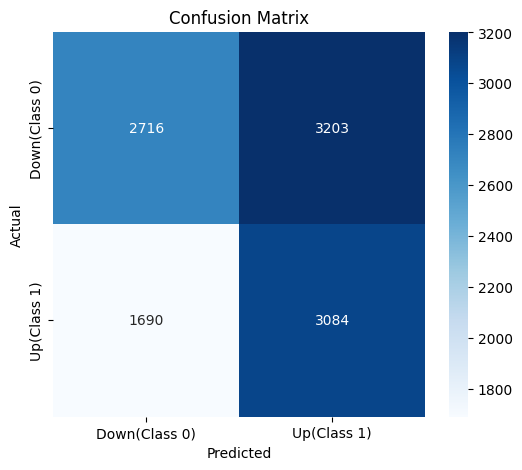

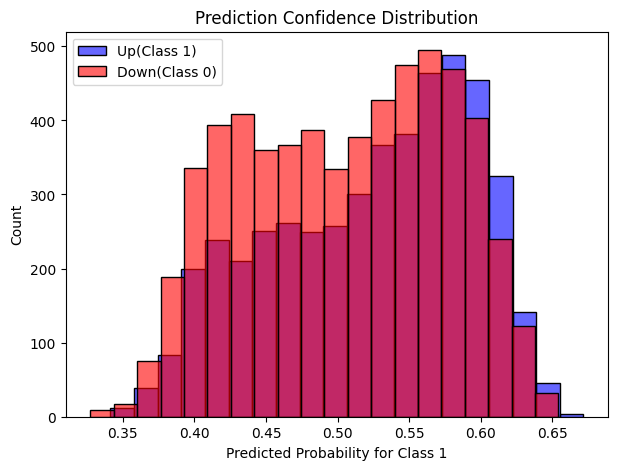

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

print(f"Accuracy: {accuracy_score(true_labels, all_predictions):.4f}")
print(classification_report(true_labels, all_predictions, zero_division=0))

conf_matrix = confusion_matrix(true_labels, all_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Down(Class 0)", "Up(Class 1)"], yticklabels=["Down(Class 0)", "Up(Class 1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(7, 5))
sns.histplot(all_probs[true_labels == 1], color="blue", label="Up(Class 1)", bins=20, alpha=0.6)
sns.histplot(all_probs[true_labels == 0], color="red", label="Down(Class 0)", bins=20, alpha=0.6)
plt.xlabel("Predicted Probability for Class 1")
plt.ylabel("Count")
plt.title("Prediction Confidence Distribution")
plt.legend()
plt.show()


Backtest Metrics for LSTM Strategy:
Duration: 2 days
Initial Capital: 1000.00, Final Capital: 1031.89
Annualized Return: 5120.27%
Annualized Volatility: 20.92%


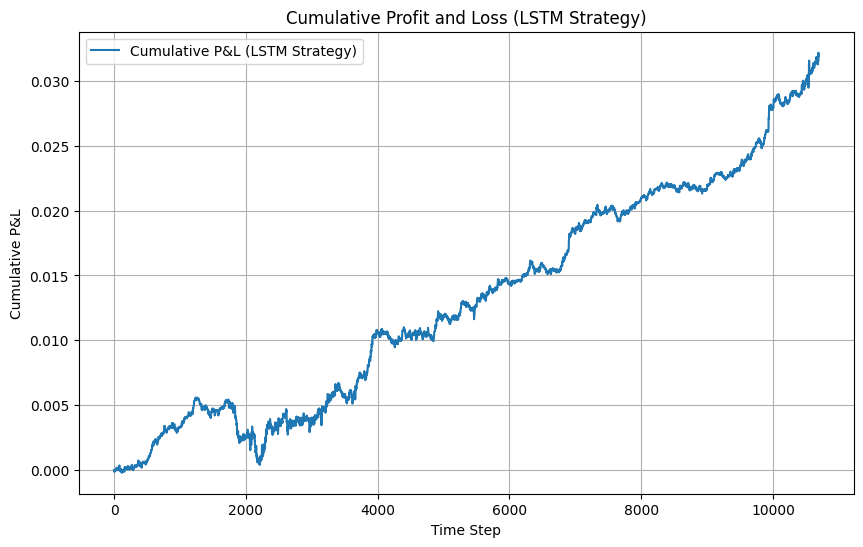

In [18]:
from finance_utils import plot_backtest_results, backtest_strategy

# Extract true percentage changes from the dataset
true_percentage_changes = test_df["mid_price_variation"].iloc[look_back:].values
timestamps = test_df.index[look_back:]

lstm_results = backtest_strategy(
    all_predictions, true_percentage_changes, timestamps, initial_capital=1000
)
plot_backtest_results(lstm_results, "LSTM Strategy")

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

logistic_train_df = pd.concat([train_df, val_df], axis=0)

# Shift y_train and y_test one step backward
y_train = logistic_train_df[prediction_column].shift(-1).dropna().astype(int)
y_test = test_df[prediction_column].shift(-1).dropna().astype(int)

# Drop the last row of X_train and X_test to align with y_train and y_test
X_train = logistic_train_df[features].iloc[:-1].values
X_test = test_df[features].iloc[:-1].values

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the logistic regression model
log_reg = LogisticRegression(solver='saga', max_iter=1000, random_state=0)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=0, solver='saga')

Test Accuracy (Logistic Regression): 0.5756
              precision    recall  f1-score   support

           0       0.60      0.70      0.65      5927
           1       0.53      0.42      0.47      4777

    accuracy                           0.58     10704
   macro avg       0.57      0.56      0.56     10704
weighted avg       0.57      0.58      0.57     10704



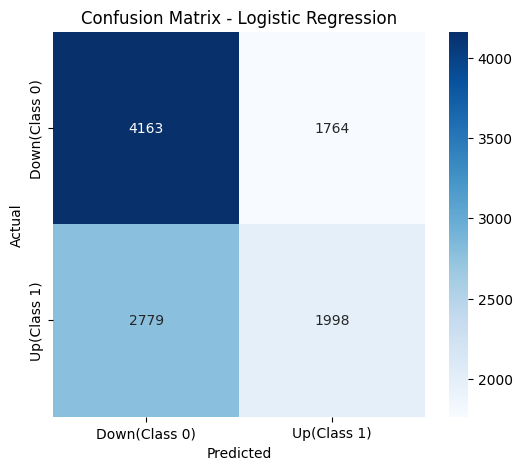

In [21]:
# Evaluate on the test set
test_predictions = log_reg.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy (Logistic Regression): {test_accuracy:.4f}")
print(classification_report(y_test, test_predictions, zero_division=0))

# Confusion Matrix for the test set
conf_matrix_log_reg = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt="d", cmap="Blues", xticklabels=["Down(Class 0)", "Up(Class 1)"], yticklabels=["Down(Class 0)", "Up(Class 1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


Backtest Metrics for Logistic Regression Strategy:
Duration: 2 days
Initial Capital: 1000.00, Final Capital: 1037.15
Annualized Return: 9806.47%
Annualized Volatility: 25.13%


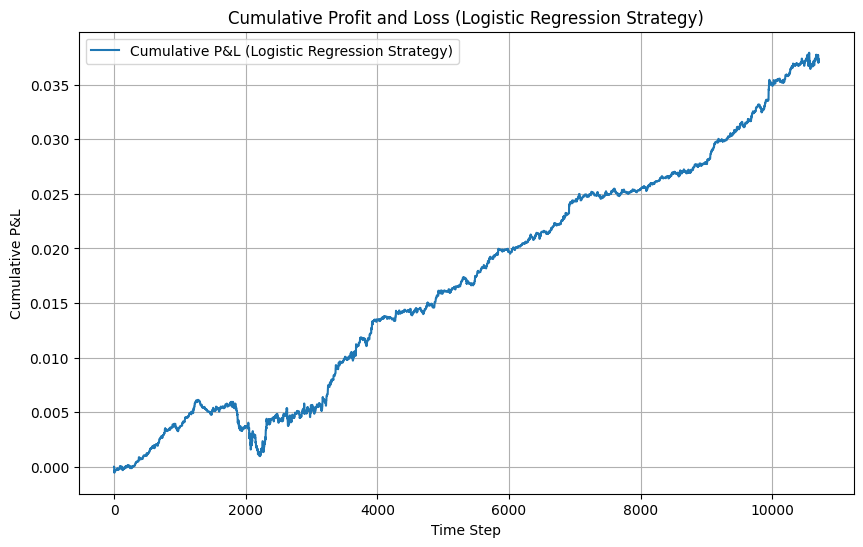

In [22]:
# Backtest the logistic regression strategy
true_percentage_changes_logistic = test_df["mid_price_variation"].iloc[1:].values
timestamps_logistic = test_df.index[1:]

log_reg_results = backtest_strategy(
    test_predictions, true_percentage_changes_logistic, timestamps_logistic, initial_capital=1000
)
plot_backtest_results(log_reg_results, "Logistic Regression Strategy")

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the logistic regression model
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=0)

Test Accuracy (Random Forest Classifier): 0.5552
              precision    recall  f1-score   support

           0       0.59      0.65      0.62      5927
           1       0.50      0.44      0.47      4777

    accuracy                           0.56     10704
   macro avg       0.55      0.54      0.54     10704
weighted avg       0.55      0.56      0.55     10704



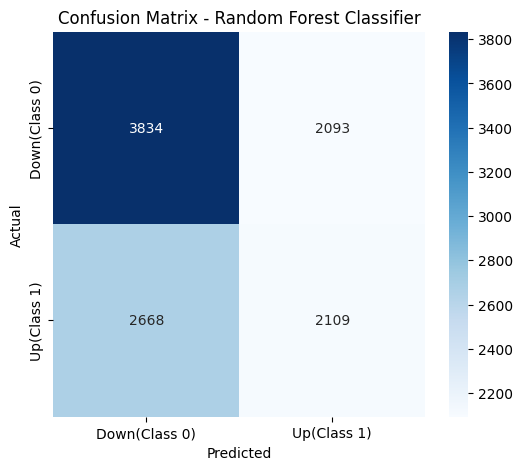

In [24]:
# Evaluate on the test set
rf_predictions = rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Test Accuracy (Random Forest Classifier): {rf_accuracy:.4f}")
print(classification_report(y_test, rf_predictions, zero_division=0))

# Confusion Matrix for the test set
conf_matrix_rf = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Down(Class 0)", "Up(Class 1)"], yticklabels=["Down(Class 0)", "Up(Class 1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()


Backtest Metrics for Random Forest Strategy:
Duration: 2 days
Initial Capital: 1000.00, Final Capital: 1027.01
Annualized Return: 2773.69%
Annualized Volatility: 17.90%


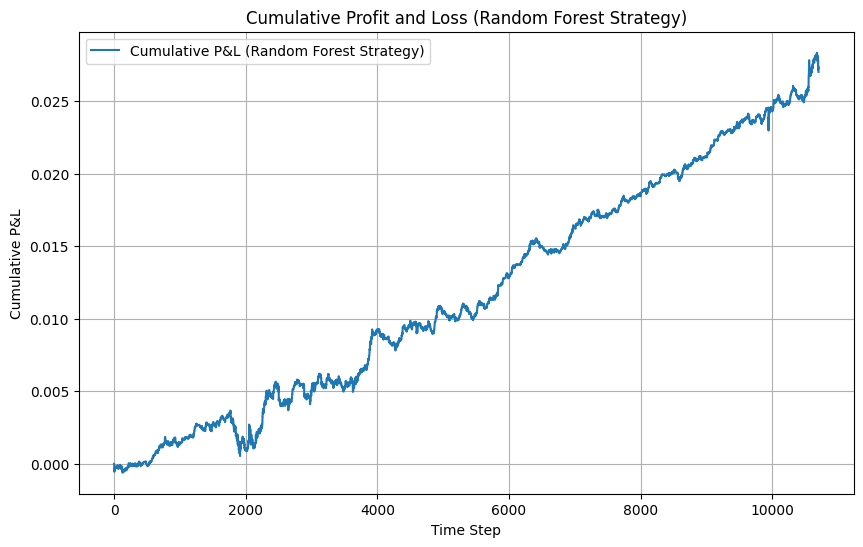

In [25]:
# Backtest the logistic regression strategy
true_percentage_changes_rf = test_df["mid_price_variation"].iloc[1:].values
timestamps_rf = test_df.index[1:]

rf_results = backtest_strategy(
    rf_predictions, true_percentage_changes_rf, timestamps_rf, initial_capital=1000
)
plot_backtest_results(rf_results, "Random Forest Strategy")

Random Prediction Accuracy: 0.4911
              precision    recall  f1-score   support

           0       0.55      0.49      0.51      5919
           1       0.44      0.50      0.47      4774

    accuracy                           0.49     10693
   macro avg       0.49      0.49      0.49     10693
weighted avg       0.50      0.49      0.49     10693



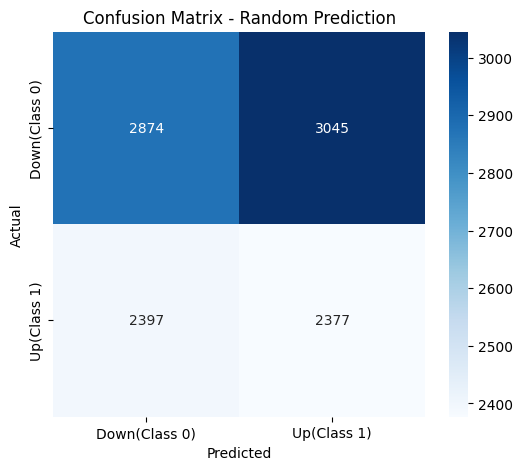

In [26]:
# Baseline strategy: Random prediction
random_predictions = np.random.randint(0, 2, size=len(true_labels))
print(f"Random Prediction Accuracy: {accuracy_score(true_labels, random_predictions):.4f}")
print(classification_report(true_labels, random_predictions, zero_division=0))

conf_matrix_random = confusion_matrix(true_labels, random_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_random, annot=True, fmt="d", cmap="Blues", xticklabels=["Down(Class 0)", "Up(Class 1)"], yticklabels=["Down(Class 0)", "Up(Class 1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Prediction")
plt.show()


Backtest Metrics for Random Strategy:
Duration: 2 days
Initial Capital: 1000.00, Final Capital: 996.87
Annualized Return: -32.61%
Annualized Volatility: 0.01%


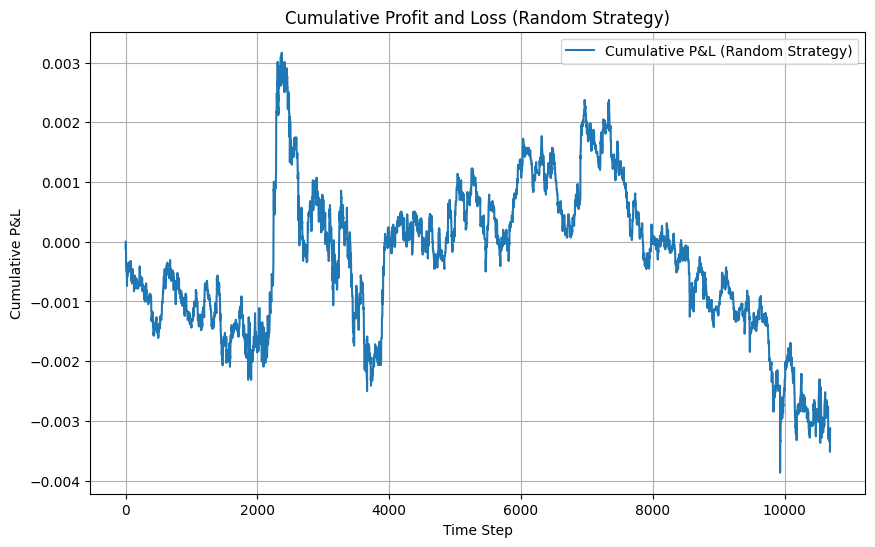

In [27]:
random_results = backtest_strategy(
    random_predictions, true_percentage_changes, timestamps, initial_capital=1000
)
plot_backtest_results(random_results, "Random Strategy")

Most Common Class Prediction Accuracy: 0.5535
              precision    recall  f1-score   support

           0       0.55      1.00      0.71      5919
           1       0.00      0.00      0.00      4774

    accuracy                           0.55     10693
   macro avg       0.28      0.50      0.36     10693
weighted avg       0.31      0.55      0.39     10693



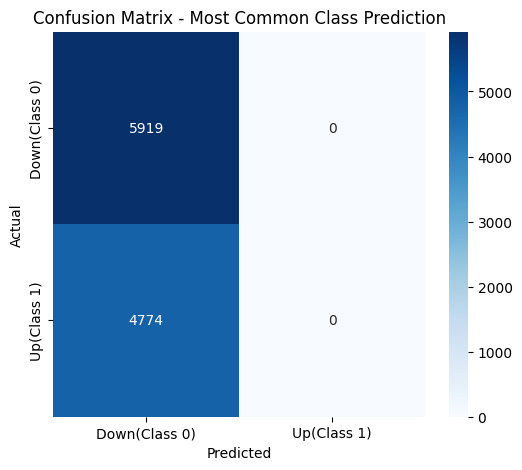

In [28]:
train_labels = []
for _, batch_y in train_loader:
    train_labels.extend(batch_y.cpu().numpy())
train_labels = np.array(train_labels)
most_common_class = np.bincount(train_labels).argmax()
most_common_predictions = np.full_like(true_labels, most_common_class)
print(f"Most Common Class Prediction Accuracy: {accuracy_score(true_labels, most_common_predictions):.4f}")
print(classification_report(true_labels, most_common_predictions, zero_division=0))

conf_matrix_most_common = confusion_matrix(true_labels, most_common_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_most_common, annot=True, fmt="d", cmap="Blues", xticklabels=["Down(Class 0)", "Up(Class 1)"], yticklabels=["Down(Class 0)", "Up(Class 1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Most Common Class Prediction")
plt.show()


Backtest Metrics for Most Common Class Strategy:
Duration: 2 days
Initial Capital: 1000.00, Final Capital: 1000.00
Annualized Return: 0.00%
Annualized Volatility: 0.00%


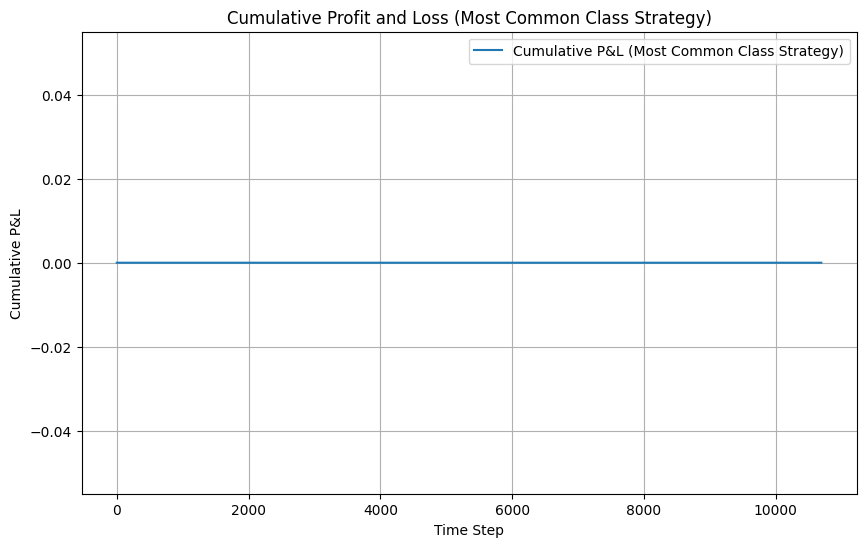

In [29]:
most_common_results = backtest_strategy(
    most_common_predictions, true_percentage_changes, timestamps, initial_capital=1000
)
plot_backtest_results(most_common_results, "Most Common Class Strategy")